In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import datetime as dt
import re
from wordcloud import WordCloud
from textblob import TextBlob
import ast
import pingouin as pg

In [ ]:
# Load dataset
fusion = pd.read_csv('/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv')

In [ ]:
# Display max rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# View first 5 rows in dataframe
fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,fr_entries,fr_entries_cumul,fr_entry_week,us_entries,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes,producers_list,producers_count,top_stars_list,top_stars_count,languages_list,languages_count,nationality_list,nationality_list_count,associated_genres_allocine_list,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,release_date_us
0,20941,"Abigail, le pouvoir de l'Elue",https://www.jpbox-office.com/cinema/images/pos...,2019,08-01-2020,00-00-0000,"U.S.A.,Russie",Anglais,1h 51min,NaN,Aleksandr Boguslavskiy,"Tinatin Dalakishvili,Eddie Marsan,Rinal Mukham...","Aleksandr Boguslavskiy,Dmitriy Zhigalov",Fantasy,"Action,Fantastique","Un siècle après le début de la Contamination, ...",-,NaN,en VOD,Condor Distribution,20000000.0,NaN,NaN,NaN,NaN,NaN,NaN,1835634.0,1.9,1.9,"241 notes, 40 critiques","241 notes, 40 critiques","47 731,vues",Winter,111.0,"['Aleksandr Boguslavskiy', 'Dmitriy Zhigalov']",2,"['Tinatin Dalakishvili', 'Eddie Marsan', 'Rina...",3,['Anglais'],1,"['U.S.A.', 'Russie']",2,"['Action', 'Fantastique']",2,0,0,0,0,0,241,0,0,0,241,40,47731.0,546,NaN
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010,10-02-2010,12-02-2010,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150000000.0,214 497,334 885,10-02-2010 – 17-02-2010,30 627 000,12-02-2010 – 15-02-2010,61937495.0,77810085.0,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0,"['Joe Johnston', 'Andrew Kevin Walker', 'David...",3,"['Benicio Del Toro', 'Anthony Hopkins', 'Emily...",3,"['Anglais', 'Roumain']",2,[],0,"['Fantastique', 'Epouvante-horreur', 'Thriller']",3,6,6,9,214497,30627000,14,1,2,3,4274,791,NaN,245,NaN
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019,01-01-2020,15-11-2019,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10000000.0,66 229,105 205,01-01-2020 – 08-01-2020,5 605 051,15-11-2019 – 18-11-2019,17156058.0,11200000.0,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0,"['Bill Condon', 'Jeffrey Hatcher']",2,"['Helen Mirren', 'Ian McKellen', 'Russell Tovey']",3,['Anglais'],1,"['U.S.A.', 'Canada']",2,"['Drame', 'Thriller']",2,1,46,2,66229,5605051,16,0,0,0,1847,186,NaN,620,NaN
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008,06-01-2010,00-00-0000,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06-01-2010 – 13-01-2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0,['Ounie Lecomte'],1,"['Kim Sae-Ron', 'Park Doyeon', 'Park Myeong-Sh...",3,['Coréen'],1,"['France', 'Corée du Sud']",2,['Drame'],1,1,0,1,16820,0,19,1,1,2,274,56,NaN,431,NaN
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008,14-04-2010,1

In [ ]:
# Filter out rows with missing 'opening_week_france_num' entries
df_fusion = fusion[fusion['opening_week_france_num'] != 0]

### 1. Descriptive Analysis

In [45]:
df_fusion.describe()

,film_id,year_of_production,budget,revenue_usa,revenue_world,press_rating,viewer_rating,duration_minutes,producers_count,top_stars_count,languages_count,nationality_list_count,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,synopsis_sentiment
count,4980.000000,4980.000000,1.488000e+03,2.485000e+03,4.185000e+03,4977.000000,4977.000000,4971.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4.980000e+03,4.980000e+03,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,442.000000,4980.000000,4980.000000
mean,13222.713454,2012.699799,5.588693e+07,4.518862e+07,4.136586e+07,3.148081,3.034237,104.076846,1.934337,2.951205,1.240361,0.792369,1.727912,17.730522,7.220080,8.819679,1.825392e+05,6.508010e+06,27.916867,0.659237,2.063454,2.722691,4286.801807,280.827711,45445.857466,364.267671,0.016772
std,7467.084573,7.060468,5.829215e+07,8.883897e+07,1.177066e+08,0.645960,0.716260,20.194052,0.758897,0.368236,0.670931,1.302223,0.845379,17.684740,14.471078,5.594521,3.410323e+05,2.165772e+07,136.534947,2.010353,4.007122,5.549392,10859.884876,467.727619,85534.472582,205.161983,0.217627
min,4.000000,2000.000000,1.000000e+05,7.400000e+01,8.720000e+02,1.000000,0.800000,26.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,-1.000000
25%,10177.750000,2007.000000,1.500000e+07,3.810520e+05,8.038900e+05,2.700000,2.500000,92.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,2.171925e+04,0.000000e+00,13.000000,0.000000,0.000000,0.000000,330.000000,47.000000,4857.500000,225.000000,0.000000
50%,14203.500000,2013.000000,3.500000e+07,7.455447e+06,3.931634e+06,3.200000,3.100000,101.000000,2.000000,3.000000,1.000000,0.000000,2.000000,12.000000,0.000000,8.000000,6.323350e+04,0.000000e+00,19.000000,0.000000,0.000000,0.000000,1059.500000,127.000000,17445.500000,340.000000,0.000000
75%,18993.500000,2018.000000,7.500000e+07,4.839019e+07,2.260629e+07,3.600000,3.600000,113.000000,2.000000,3.000000,1.000000,2.000000,2.000000,34.000000,2.000000,11.000000,1.860752e+05,3.162500e+05,24.000000,0.000000,3.000000,3.000000,3205.250000,310.000000,46131.500000,470.250000,0.000000
max,24570.000000,2025.000000,3.560000e+08,9.366622e+08,1.939428e+09,4.900000,4.700000,372.000000,5.000000,3.000000,9.000000,9.000000,7.000000,52.000000,52.000000,58.000000,4.378720e+06,3.571150e+08,6149.000000,54.000000,48.000000,102.000000,206210.000000,7291.000000,721890.000000,1672.000000,1.000000


#### What year was the most (or least) films produced since 2000?

In [ ]:
# Get the most frequent value in the 'year_of_production' column
top_production_year = df_fusion['year_of_production'].value_counts(sort=True).head(1)
least_production_year = df_fusion['year_of_production'].value_counts(sort=True).tail(1)

year_of_production
2023    265
Name: count, dtype: int64

#### What films had the highest/lowest budgets

In [52]:
film_with_max_budget = df_fusion.loc[df_fusion['budget'] == df_fusion['budget'].max(), ['film_title', 'budget']]
film_with_least_budget = df_fusion.loc[df_fusion['budget'] == df_fusion['budget'].min(), ['film_title', 'budget']]

print(film_with_max_budget)
print(film_with_least_budget)

            film_title       budget
231  Avengers: Endgame  356000000.0
         film_title    budget
323       Le Cercle  100000.0
1488  A Ghost Story  100000.0


#### What genres had the highest/lowest budgets

In [ ]:
# Get the max budget per genre
max_budget_per_genre = df_fusion.groupby('main_genre_jpboxoffice')['budget'].max()

# Get the max budget value
max_budget_value = max_budget_per_genre.max()

# Find the genre with the overall highest max budget
genre_with_max_budget = max_budget_per_genre.idxmax()

# Get the max budget per genre
min_budget_per_genre = df_fusion.groupby('main_genre_jpboxoffice')['budget'].min()

# Get the max budget value
max_budget_value = max_budget_per_genre.max()

# Find the genre with the overall highest max budget
genre_with_min_budget = min_budget_per_genre.idxmax()

print(genre_with_max_budget)
print(genre_with_min_budget)

Comicbook
Catastrophe


#### View distribution of entries in France

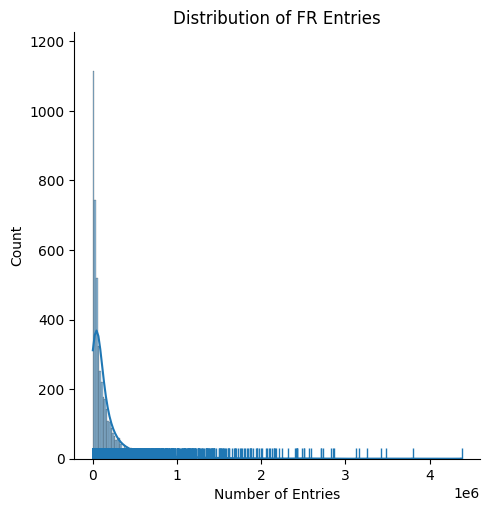

In [44]:
sns.displot(df_fusion['opening_week_france_num'], kde=True, rug=True)
plt.title('Distribution of FR Entries')
plt.xlabel('Number of Entries')
plt.show()

#### 2. Multivariate Analysis

In [6]:
def multi_stats(df):  # sourcery skip: extract-method, merge-comparisons
    # Top Genres
    top_genres = df['main_genre_jpboxoffice'].value_counts().head(10).reset_index()
    top_genres.columns = ['Genre', 'Count']
    
    # Top actors
    if 'top_stars_list' in df.columns:
        actors_series = df['top_stars_list'].dropna()
        exploded_actors = actors_series.explode()
        top_actors = exploded_actors.value_counts().head(10).to_frame(name='Appearances')
        top_actors.index.name = 'Actor'
        top_actors.reset_index(inplace=True)
        # Remove rows where Actor is an empty list or empty string
        top_actors = top_actors[top_actors['Actor'].apply(lambda x: x != "[]" and x != '')]
    else:
        top_actors = pd.DataFrame(columns=['Actor', 'Appearances'])

    # Average Movie Duration Per Year
    avg_movie_dur = (
        df.groupby('year_of_production')['duration_minutes']
        .mean()
        .reset_index()
        .sort_values(by='year_of_production')
    )
    avg_movie_dur.columns = ['Year', 'Average_Duration_Minutes']

    return top_genres, top_actors, avg_movie_dur

In [7]:
top_genres, top_actors, avg_movie_dur = multi_stats(df_fusion)

In [8]:
def plot_distribution(top_genres, top_actors, avg_movie_dur):
    # Top Genres
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')
    plt.title('Top Genres')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genre')
    plt.tight_layout()
    plt.show()

    # Top Actors
    if not top_actors.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma')
        plt.title('Top Actors by Number of Appearances')
        plt.xlabel('Number of Appearances')
        plt.ylabel('Actor')
        plt.tight_layout()
        plt.show()
    else:
        print("No actor data to display.")

    # Average Movie Duration per Year
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=avg_movie_dur, x='Year', y='Average_Duration_Minutes', marker='o', color='orange')
    plt.title('Average Movie Duration Per Year')
    plt.xlabel('Year')
    plt.ylabel('Duration (minutes)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_72344/3449578680.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')


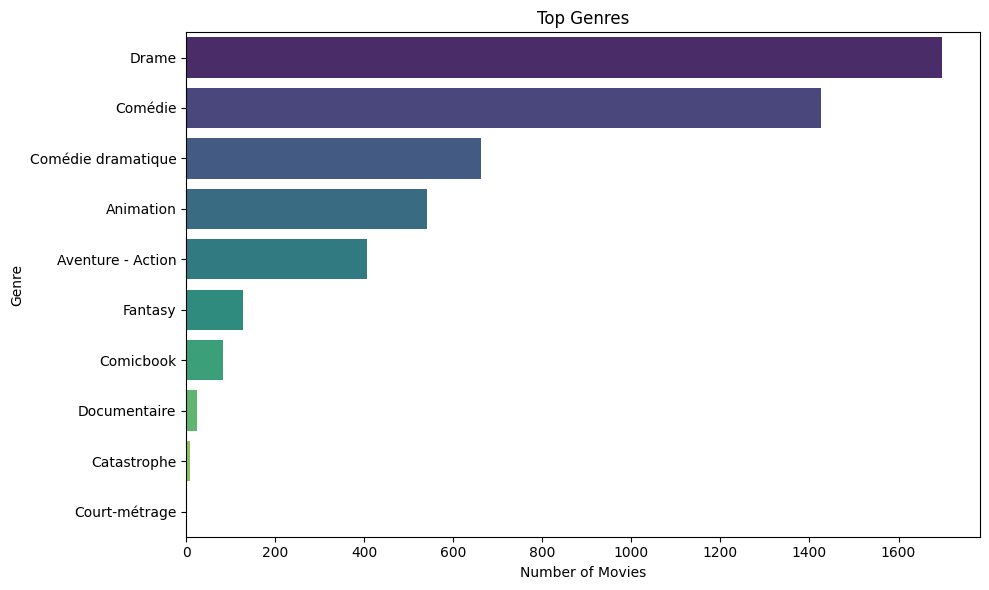

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_72344/3449578680.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma')


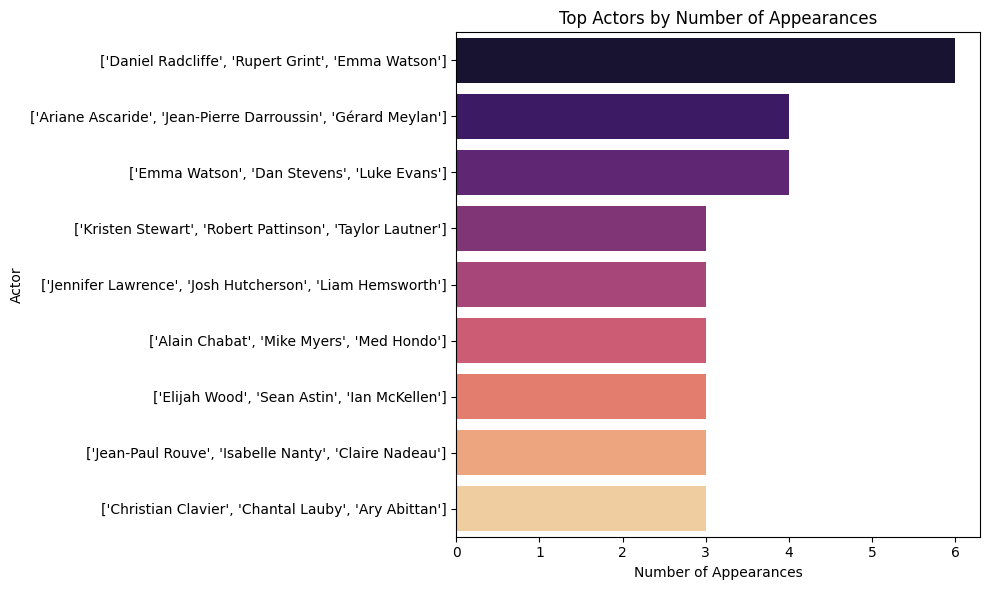

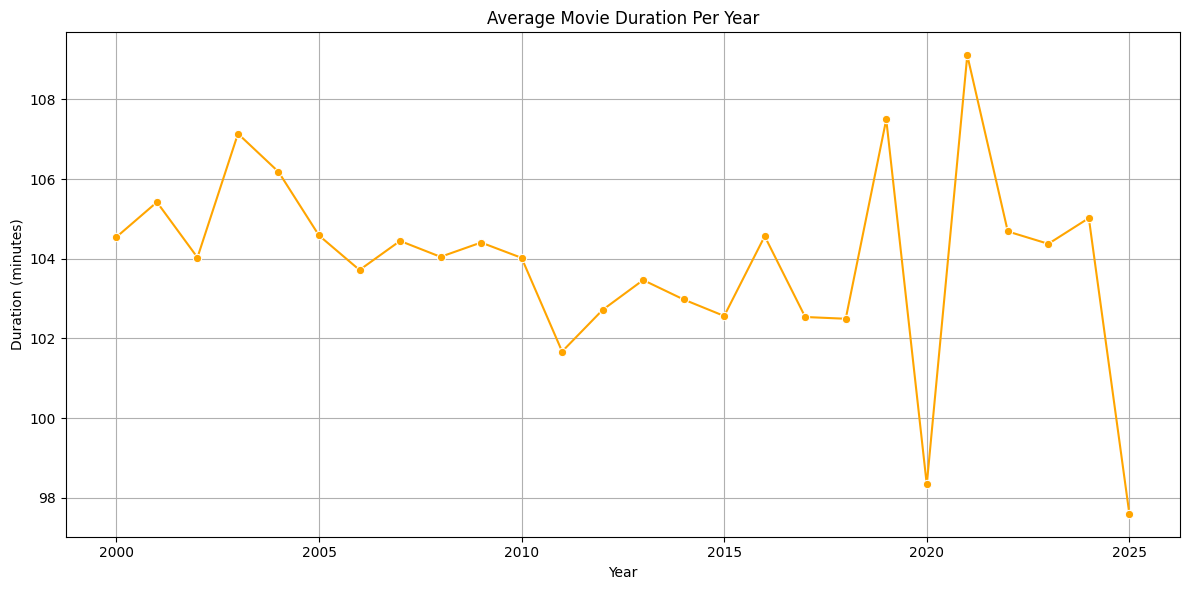

In [9]:
plot_distribution(top_genres, top_actors, avg_movie_dur)

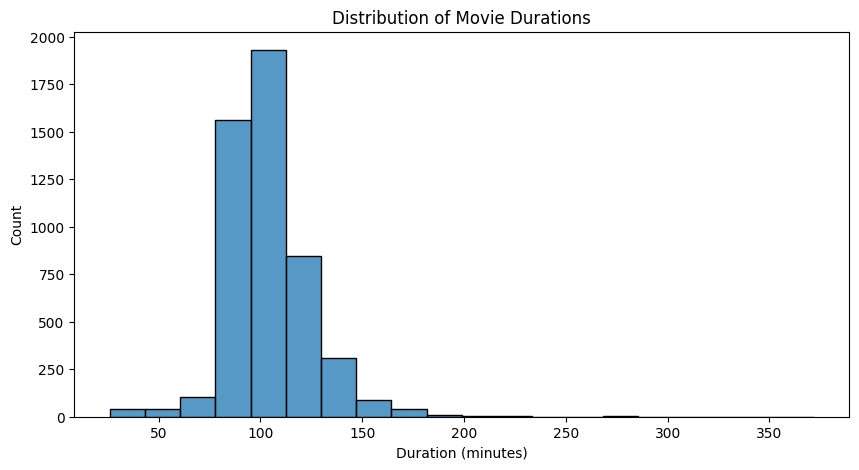

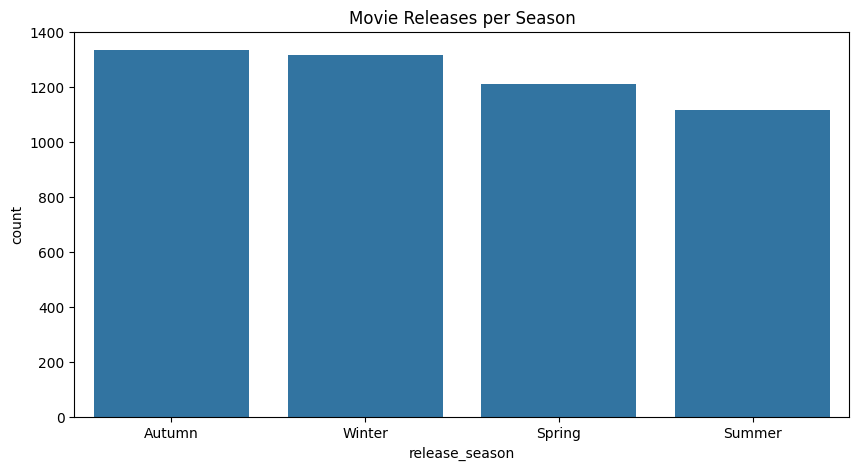

In [10]:
def plot_distribution(df):
    plt.figure(figsize=(10,5))
    sns.histplot(df['duration_minutes'].dropna(), bins=20)
    plt.title('Distribution of Movie Durations')
    plt.xlabel('Duration (minutes)')
    plt.show()

    plt.figure(figsize=(10,5))
    sns.countplot(x='release_season', data=df, order=df['release_season'].value_counts().index)
    plt.title('Movie Releases per Season')
    plt.show()

plot_distribution(df_fusion)

#### 2. Performance Analysis (Bivariate and Multi-variate Analysis)

In [11]:
def genre_performance(df):
    genre_perf = (
        df.groupby('main_genre_jpboxoffice')[['opening_week_france_num', 'viewer_rating']]
        .mean()
        .sort_values(by='opening_week_france_num', ascending=False)
        .reset_index()
    )
    return genre_perf

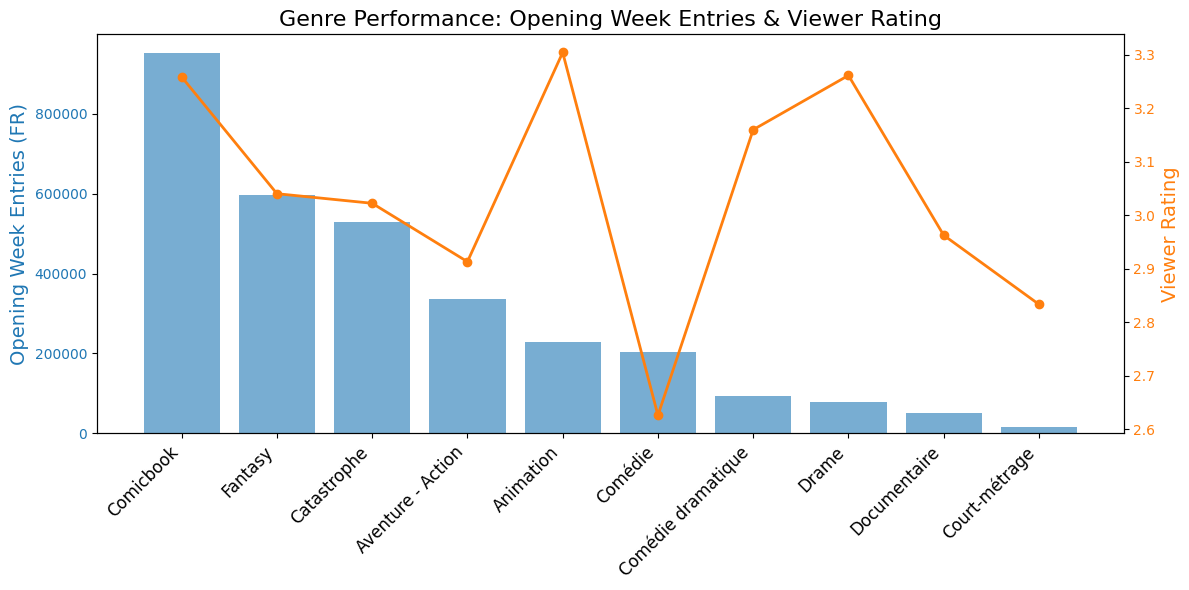

In [12]:
def plot_genre_performance_dual_axis(genre_perf_df):
    df_sorted = genre_perf_df.sort_values(by='opening_week_france_num', ascending=False)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    genres = df_sorted['main_genre_jpboxoffice']
    x = np.arange(len(genres))

    color1 = 'tab:blue'
    ax1.bar(x, df_sorted['opening_week_france_num'], color=color1, alpha=0.6, label='Opening Week Entries')
    ax1.set_ylabel('Opening Week Entries (FR)', color=color1, fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(genres, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(x, df_sorted['viewer_rating'], color=color2, marker='o', linewidth=2, label='Viewer Rating')
    ax2.set_ylabel('Viewer Rating', color=color2, fontsize=14)
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.title('Genre Performance: Opening Week Entries & Viewer Rating', fontsize=16)
    fig.tight_layout()
    plt.show()


genre_perf_df = genre_performance(df_fusion)
plot_genre_performance_dual_axis(genre_perf_df)

In [13]:
def actor_success_1(df):
    exploded = df[['top_stars_list', 'revenue_world']].explode('top_stars_list')
    actor_rev = exploded.groupby('top_stars_list')['revenue_world'].mean().sort_values(ascending=False)
    
    print("\n--- Top Revenue-Generating Actors ---")
    actors_suc = actor_rev.head(10).reset_index()
    actors_suc.columns = ['Actor', 'Average_Revenue_World']
    
    return actors_suc


--- Top Revenue-Generating Actors ---
                                               Actor  Average_Revenue_World
0  ['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...           1.939428e+09
1  ['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...           1.369896e+09
2     ['Vin Diesel', 'Paul Walker', 'Jason Statham']           1.163039e+09
3     ['Daisy Ridley', 'John Boyega', 'Adam Driver']           1.131561e+09
4  ['Rayane Bensetti', 'Donald Glover', 'Anne Sila']           1.113305e+09
5  ['Charlotte Le Bon', 'Amy Poehler', 'Jaynelia ...           1.023200e+09
6  ['Chris Pratt', 'Bryce Dallas Howard', 'Nick R...           1.019443e+09
7  ['Vin Diesel', 'Dwayne Johnson', 'Jason Statham']           1.009997e+09
8  ['Chris Pratt', 'Bryce Dallas Howard', 'Rafe S...           8.917647e+08
9    ['Emmylou Homs', 'Kristen Bell', 'Anaïs Delva']           8.757423e+08


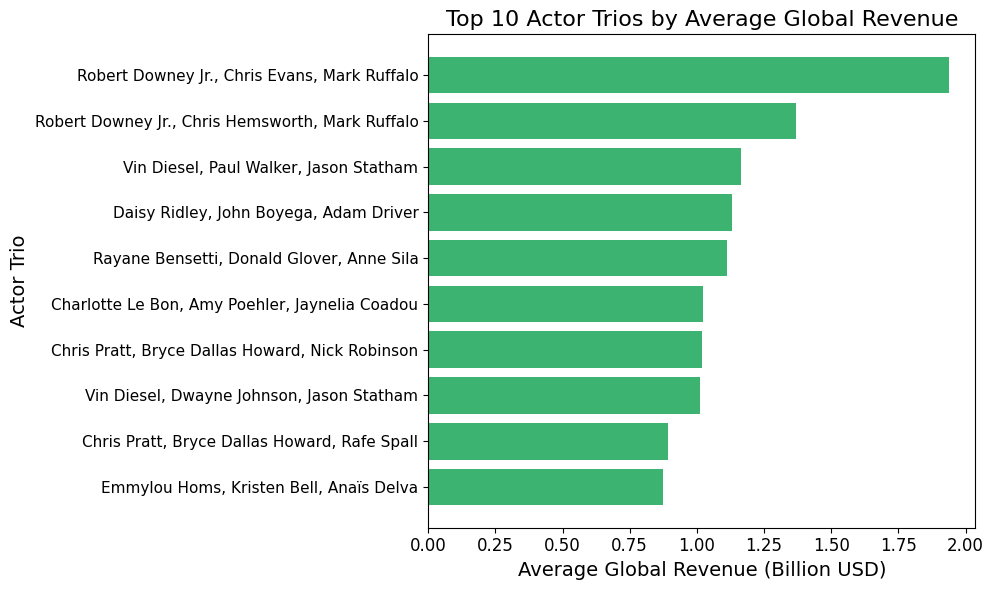

In [14]:
def plot_actor_trio_success(actor_rev_df):
    # Convert stringified lists to actual lists
    actor_rev_df['Actor_Label'] = actor_rev_df['Actor'].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
    )

    # Convert revenue to billions
    actor_rev_df['Revenue_Billion'] = actor_rev_df['Average_Revenue_World'] / 1e9

    # Sort by revenue for barh plot
    plot_df = actor_rev_df.sort_values(by='Revenue_Billion', ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        plot_df['Actor_Label'],
        plot_df['Revenue_Billion'],
        color='mediumseagreen'
    )
    plt.title('Top 10 Actor Trios by Average Global Revenue', fontsize=16)
    plt.xlabel('Average Global Revenue (Billion USD)', fontsize=14)
    plt.ylabel('Actor Trio', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


actor_rev_df = actor_success_1(df_fusion)
print(actor_rev_df)
plot_actor_trio_success(actor_rev_df)


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_72344/3682871987.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')


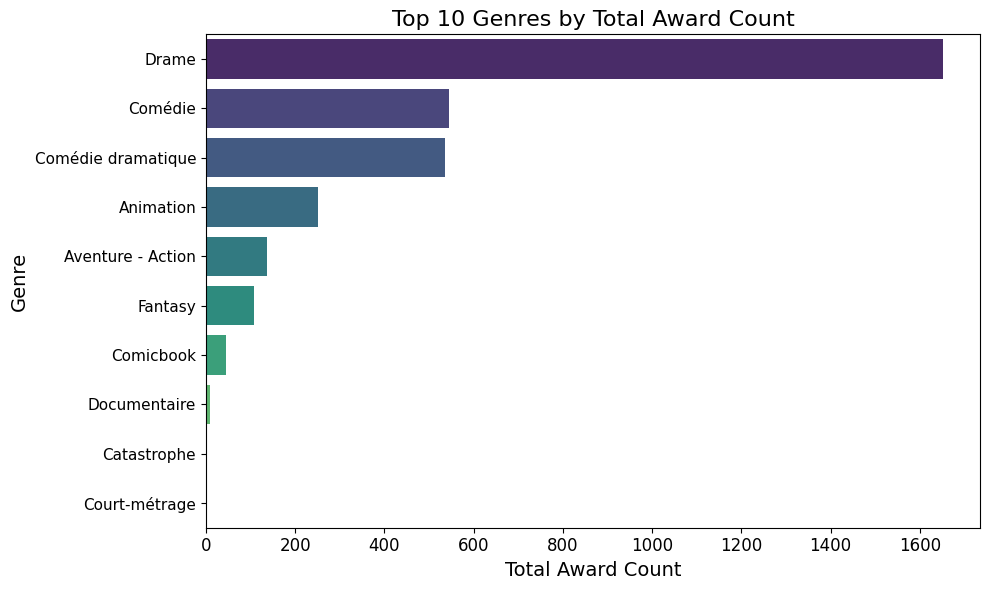

In [15]:
def plot_genre_awards(df):
    # Handle multiple genres per movie
    exploded = df[['main_genre_jpboxoffice', 'award_count']].copy()
    exploded['main_genre_jpboxoffice'] = exploded['main_genre_jpboxoffice'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
    exploded = exploded.explode('main_genre_jpboxoffice')

    # Group by genre and sum awards
    genre_awards = exploded.groupby('main_genre_jpboxoffice')['award_count'].sum().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')
    plt.title('Top 10 Genres by Total Award Count', fontsize=16)
    plt.xlabel('Total Award Count', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_genre_awards(df_fusion)

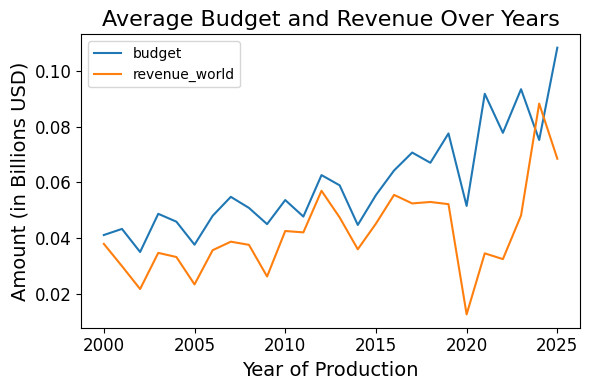

In [16]:
# # Time-Series Analysis

def trend_budget_revenue(df):
    # Group by year and calculate mean
    yearly = df.groupby('year_of_production')[['budget', 'revenue_world']].mean()

    # Convert to billions
    yearly_billion = yearly / 1e9

    # Plot
    plt.figure(figsize=(6, 4))
    yearly_billion.plot(ax=plt.gca())
    plt.title("Average Budget and Revenue Over Years", fontsize=16)
    plt.ylabel('Amount (in Billions USD)', fontsize=14)
    plt.xlabel('Year of Production', fontsize=14)
    # plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

trend_budget_revenue(df_fusion)

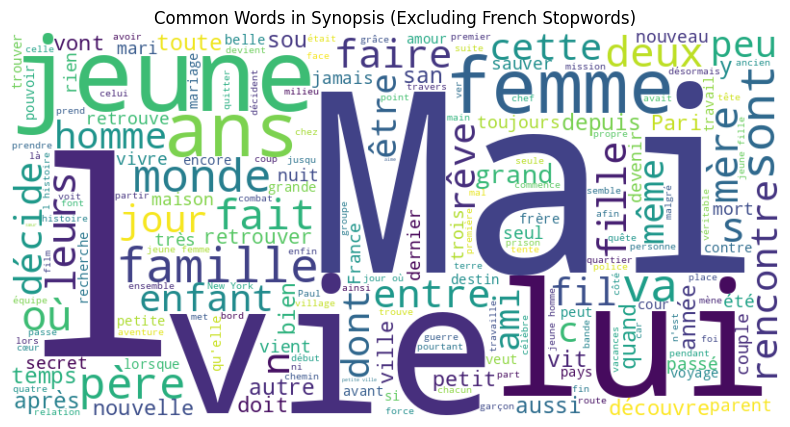

In [17]:
# --- 7. Text Analysis ---

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt

def generate_wordcloud(df):
    # Define French stopwords (you can expand this list if needed)
    french_stopwords = set([
        'd', 'alors', 'et', 'est', 'd\'une', 'd\'un', 'la', 'le', 'les', 'des', 'du', 'de', 'un', 'une', 'en', 'dans', 'que', 'qui', 
        'pour', 'sur', 'par', 'au', 'aux', 'ce', 'ces', 'son', 'sa', 'ses', 'ne', 'pas', 'ou', '1', 'qu', 'qu\'il', 'ont', 'c\'est',
        'plus', 'avec', 'il', 'elle', 'ils', 'leur', 'tout', 'tous', 'elles', 'nous', 'vous', 'se', 'comme', 'a', 'à', 'n\'a',
    ])

    # Combine with default stopwords
    custom_stopwords = STOPWORDS.union(french_stopwords)

    text = ' '.join(df['synopsis'].dropna().astype(str).tolist())
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Common Words in Synopsis (Excluding French Stopwords)")
    plt.show()



generate_wordcloud(df_fusion)

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_72344/119896732.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)


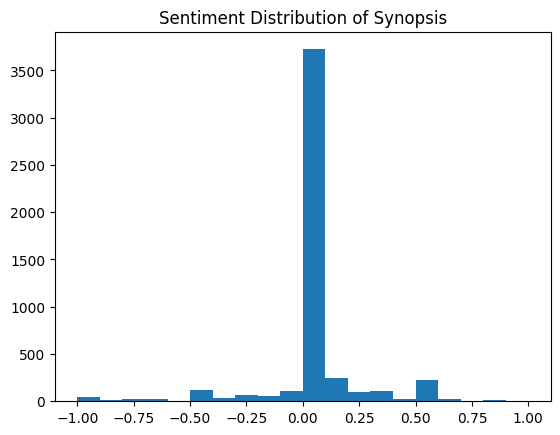

In [18]:
def sentiment_synopsis(df):
    df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plt.hist(df['synopsis_sentiment'], bins=20)
    plt.title("Sentiment Distribution of Synopsis")
    plt.show()

sentiment_synopsis(df_fusion)

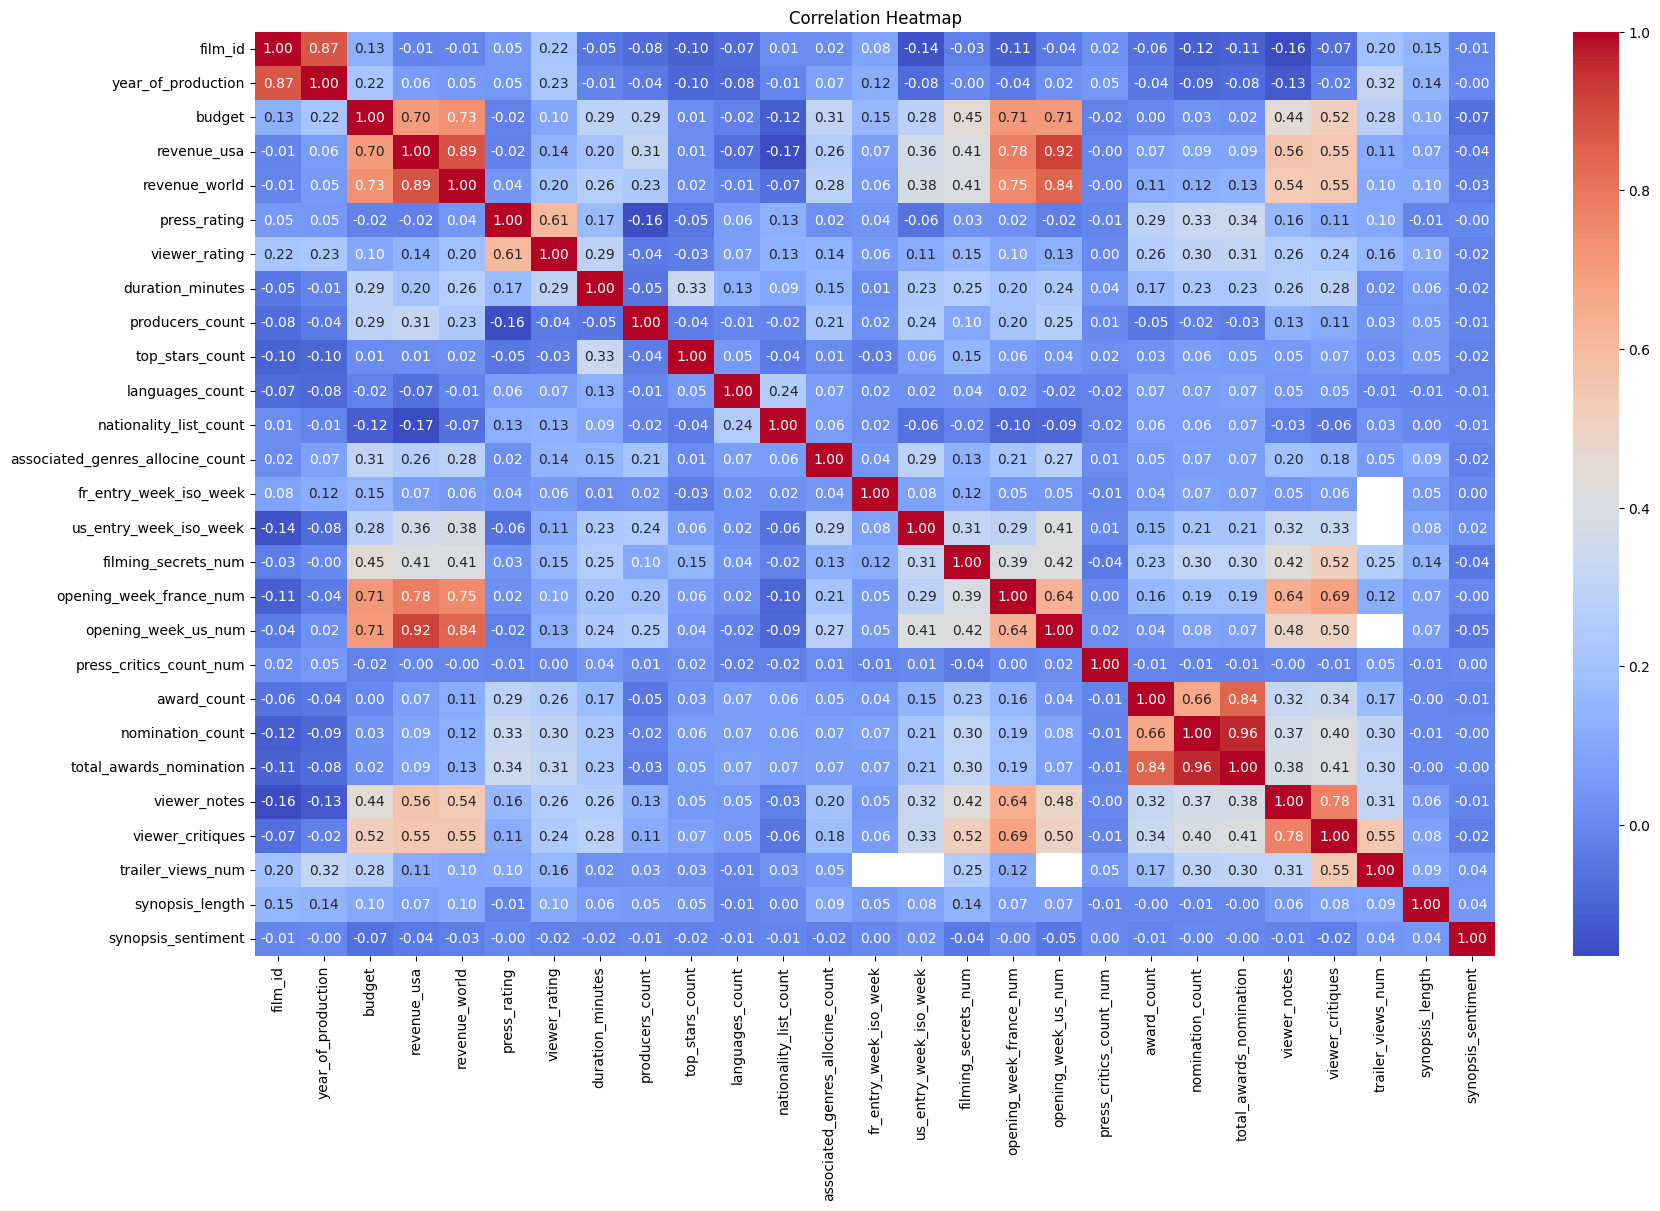

In [19]:
# --- 6. Correlation ---

def correlation_matrix(df):
    numeric_cols = df.select_dtypes(include=np.number)
    corr = numeric_cols.corr()
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

correlation_matrix(df_fusion)

In [20]:
df_fusion.head()

,film_id,film_title,image_url,year_of_production,release_date_france,release_date_usa,nationality,languages,duration,age_classification,director,top_stars,producers,main_genre_jpboxoffice,associated_genres_allocine,synopsis,filming_secrets,awards,broadcast_category,distributor,budget,fr_entries,fr_entries_cumul,fr_entry_week,us_entries,us_entry_week,revenue_usa,revenue_world,press_rating,viewer_rating,press_critics_count,viewer_critics_count,trailer_views,release_season,duration_minutes,producers_list,producers_count,top_stars_list,top_stars_count,languages_list,languages_count,nationality_list,nationality_list_count,associated_genres_allocine_list,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length,release_date_us,synopsis_sentiment
1,10280,Wolfman,https://www.jpbox-office.com/cinema/images/pos...,2010,10-02-2010,12-02-2010,NaN,"Anglais, Roumain",1h 43min,Interdit - 12 ans,Joe Johnston,"Benicio Del Toro,Anthony Hopkins,Emily Blunt","Joe Johnston,Andrew Kevin Walker,David Self",Fantasy,"Fantastique,Epouvante-horreur,Thriller",Lawrence Talbot est un aristocrate torturé que...,9 anecdotes,1 prix et 2 nominations,en salle,Universal Pictures International France,150000000.0,214 497,334 885,10-02-2010 – 17-02-2010,30 627 000,12-02-2010 – 15-02-2010,61937495.0,77810085.0,3.1,2.4,14 critiques,"4274 notes, 791 critiques",NaN,Winter,103.0,"['Joe Johnston', 'Andrew Kevin Walker', 'David...",3,"['Benicio Del Toro', 'Anthony Hopkins', 'Emily...",3,"['Anglais', 'Roumain']",2,[],0,"['Fantastique', 'Epouvante-horreur', 'Thriller']",3,6,6,9,214497,30627000,14,1,2,3,4274,791,NaN,245,NaN,-1.000000
2,19775,L'Art du mensonge,https://www.jpbox-office.com/cinema/images/pos...,2019,01-01-2020,15-11-2019,"U.S.A.,Canada",Anglais,1h 50min,NaN,Bill Condon,"Helen Mirren,Ian McKellen,Russell Tovey","Bill Condon,Jeffrey Hatcher",Drame,"Drame,Thriller","Escroc professionnel, Roy Courtnay a déjà en v...",2 anecdotes,NaN,en salle,Warner Bros. France,10000000.0,66 229,105 205,01-01-2020 – 08-01-2020,5 605 051,15-11-2019 – 18-11-2019,17156058.0,11200000.0,2.7,3.5,16 critiques,"1847 notes, 186 critiques",NaN,Winter,110.0,"['Bill Condon', 'Jeffrey Hatcher']",2,"['Helen Mirren', 'Ian McKellen', 'Russell Tovey']",3,['Anglais'],1,"['U.S.A.', 'Canada']",2,"['Drame', 'Thriller']",2,1,46,2,66229,5605051,16,0,0,0,1847,186,NaN,620,NaN,0.000000
3,11195,Une vie toute neuve,https://www.jpbox-office.com/cinema/images/pos...,2008,06-01-2010,00-00-0000,"France,Corée du Sud",Coréen,1h 32min,NaN,Ounie Lecomte,"Kim Sae-Ron,Park Doyeon,Park Myeong-Shin",Ounie Lecomte,Drame,Drame,"Séoul, 1975. Jinhee a 9 ans. Son père la place...",1 anecdote,1 prix et 1 nomination,en salle,Diaphana Films,NaN,16 820,60 220,06-01-2010 – 13-01-2010,NaN,NaN,NaN,NaN,3.7,3.8,19 critiques,"274 notes, 56 critiques",NaN,Winter,92.0,['Ounie Lecomte'],1,"['Kim Sae-Ron', 'Park Doyeon', 'Park Myeong-Sh...",3,['Coréen'],1,"['France', 'Corée du Sud']",2,['Drame'],1,1,0,1,16820,0,19,1,1,2,274,56,NaN,431,NaN,0.000000
4,11019,"New York, I Love You",https://www.jpbox-office.com/cinema/images/pos...,2008,14-04-2010,16-10-2009,NaN,Anglais,1h 43min,NaN,Mira Nair,"Hayden Christensen,Rachel Bilson,Andy Garcia","Mira Nair,Fatih Akın,Yvan Attal",Court-métrage,Comédie dramatique,"Depuis l'invention du cinéma, New York n'a jam...",15 anecdotes,NaN,en salle,Metropolitan FilmExport,14700000.0,39 797,103 782,14-04-2010 – 21-04-2010,NaN,NaN,1585787.0,6427072.0,2.8,2.7,16 critiques,"1472 notes, 166 critiques",NaN,Spring,103.0,"['Mira Nair', 'Fatih Akın', 'Yvan Attal']",3,"['Hayden Christensen', 'Rachel Bilson', 'Andy ...",3,['Anglais'],1,[],0,['Comédie dramatique'],1,15,0,15,39797,0,16,0,0,0,1472,166,NaN,353,NaN,0.136364
5,2225,Pas d'histoires ! 12 regards sur le racisme au...,https://www.jpbox-office.c

### 

In [22]:
df_analysis = df_fusion[['opening_week_france_num', 'film_id', 'year_of_production',
       'release_date_france', 'release_date_usa', 'age_classification', 'director',
       'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
       'broadcast_category', 'distributor', 'budget', 'revenue_usa', 'revenue_world',
       'press_rating', 'viewer_rating', 'release_season',
       'duration_minutes', 'producers_list', 'producers_count',
       'top_stars_list', 'top_stars_count', 'languages_list',
       'languages_count', 'nationality_list', 'nationality_list_count',
       'associated_genres_allocine_list', 'associated_genres_allocine_count',
       'fr_entry_week_iso_week', 'us_entry_week_iso_week',
       'filming_secrets_num', 'opening_week_us_num',
       'press_critics_count_num', 'award_count', 'nomination_count',
       'total_awards_nomination', 'viewer_notes', 'viewer_critiques',
       'trailer_views_num', 'synopsis_length',
       'synopsis_sentiment']].copy()

In [ ]:
df_analysis['nationality_list'].value_counts()

In [ ]:
'age_classification', 'opening_week_france_num', 'release_date_france', 'release_date_usa', 'director', 'main_genre_jpboxoffice',
'broadcast_category', 'release_season', 'producers_list', 'top_stars_list', 'languages_list', 'nationality_list',
'associated_genres_allocine_list', 


In [24]:
df_analysis['age_classification'] = df_analysis['age_classification'].fillna('Unavailable')

In [27]:
# Testing if 'age_classification' affects 'fr_entries'

anova_result = stats.f_oneway(
    df_analysis[df_analysis['age_classification'] == 'Tout public']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Interdit - 12 ans']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Tout public avec avertissement']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Interdit - 16 ans']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Interdit - 12 ans avec avertissement']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Interdit - 16 ans avec avertissement']['opening_week_france_num'],
    df_analysis[df_analysis['age_classification'] == 'Interdit - 18 ans']['opening_week_france_num'],
)

# Convert result to DataFrame
anova_df = pd.DataFrame({
    'F-statistic': [anova_result.statistic],
    'p-value': [anova_result.pvalue]
})

print(anova_df)

   F-statistic   p-value
0     1.955096  0.070212


In [ ]:
# Group and filter groups with at least 5 samples
grouped = df_analysis.groupby('age_classification')['opening_week_france_num']
valid_groups = [group.dropna() for name, group in grouped if len(group.dropna()) >= 5]

# Run ANOVA on valid groups
anova_result = stats.f_oneway(*valid_groups)

# Format result as DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
})

print(anova_df)

   F-statistic   p-value
0     3.775299  0.000938


In [32]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt

# Group and filter groups with at least 5 samples
grouped = df_analysis.groupby('age_classification')['opening_week_france_num']
valid_data = [(name, group.dropna()) for name, group in grouped if len(group.dropna()) >= 5]
valid_groups = [group for _, group in valid_data]
valid_group_names = [name for name, _ in valid_data]

# Run ANOVA
anova_result = stats.f_oneway(*valid_groups)

# Format result as DataFrame
anova_df = pd.DataFrame({
    "F-statistic": [anova_result.statistic],
    "p-value": [anova_result.pvalue]
})
print(anova_df)

# === Post-hoc test (Tukey HSD) ===
# Filter original dataframe to include only valid group names
filtered_df = df_analysis[df_analysis['age_classification'].isin(valid_group_names)]

tukey = pairwise_tukeyhsd(
    endog=filtered_df['opening_week_france_num'],
    groups=filtered_df['age_classification'],
    alpha=0.05
)

print(tukey.summary())

   F-statistic   p-value
0     3.775299  0.000938
                                     Multiple Comparison of Means - Tukey HSD, FWER=0.05                                     
               group1                               group2                  meandiff   p-adj     lower        upper    reject
-----------------------------------------------------------------------------------------------------------------------------
                   Interdit - 12 ans Interdit - 12 ans avec avertissement  -39650.4619  0.998 -252147.2731 172846.3493  False
                   Interdit - 12 ans                    Interdit - 16 ans -106478.8826 0.6963 -305449.2684  92491.5032  False
                   Interdit - 12 ans Interdit - 16 ans avec avertissement -142112.2619 0.9691 -596600.5731 312376.0493  False
                   Interdit - 12 ans                          Tout public   83164.8925 0.1092   -9098.1044 175427.8895  False
                   Interdit - 12 ans       Tout public avec avertiss

In [31]:

pg.welch_anova(dv='opening_week_france_num', between='age_classification', data=df_analysis)

,Source,ddof1,ddof2,F,p-unc,np2
0,age_classification,7,16.785771,15.585467,0.000003,0.004591


In [43]:
from scipy.stats import kruskal

grouped = df_analysis.groupby('main_genre_jpboxoffice')['opening_week_france_num']
valid_groups = [group.dropna() for name, group in grouped if len(group.dropna()) >= 5]
kw_result = kruskal(*valid_groups)
print(f"Kruskal-Wallis statistic: {kw_result.statistic}, p-value: {kw_result.pvalue}")

Kruskal-Wallis statistic: 755.256608550312, p-value: 9.007584104630565e-158
